In [9]:
mu = 100 * ((0.7**3) * (0.3**2) * 10 + (0.7 ** 4) * (0.3) * 5 + (0.7**5))
print(mu)

83.69199999999998


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# отключим предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [11]:
def delete_nan(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table  

In [12]:
data = pd.read_csv('credit_scoring_sample.csv', sep =';')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [13]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

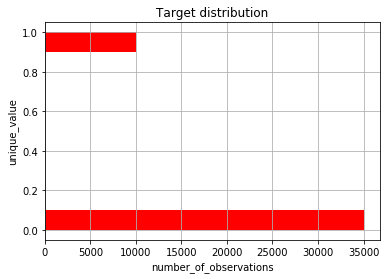

In [14]:
ax =data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

In [37]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [16]:
table =delete_nan(data)

In [17]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

In [19]:
import numpy as np

def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries


bad_credits = data[data['SeriousDlqin2yrs'] == 1]['age'].values
ok_credits = data[data['SeriousDlqin2yrs'] == 0]['age'].values

# ставим seed для воспроизводимости результатов
np.random.seed(0)

# генерируем выборки с помощью бутстрэра и сразу считаем по каждой из них среднее
bad_credits_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(bad_credits, 1000)]
ok_credits_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(ok_credits, 1000)]

#  выводим интервальную оценку среднего
print("Bad",  stat_intervals(bad_credits_scores, 0.1))
print("Ok",  stat_intervals(ok_credits_scores, 0.1))

Bad [45.71379414 46.12700479]
Ok [52.59470132 52.85480064]


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Используем модуль LogisticRegression для построения логистической регрессии.
## Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
## Используем также параметр random_state=5 для воспроизводимости результатов
lr = LogisticRegression(random_state=5, class_weight= 'balanced')

## Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
## Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая не будет переобучена, с одной стороны, 
## и будет хорошо предсказывать значения таргета, с другой.
## Остальные параметры оставляем по умолчанию.
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

## Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть 
## значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [26]:
from sklearn.metrics import roc_auc_score, make_scorer

scorer = make_scorer(roc_auc_score)

gcv = GridSearchCV(
    lr, 
    parameters, 
    n_jobs=-1, 
    cv=skf, 
    verbose=1, 
    scoring=scorer)

gcv.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=5,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=1)

In [33]:
gcv.score(X, y)

0.7212731229653147

Populating the interactive namespace from numpy and matplotlib
Feature ranking:
1. DebtRatio 0.297996 
2. MonthlyIncome 0.200164 
3. NumberOfTimes90DaysLate 0.185692 
4. age 0.149302 
5. NumberOfTime30-59DaysPastDueNotWorse 0.083185 
6. NumberOfDependents 0.047421 
7. NumberOfTime60-89DaysPastDueNotWorse 0.036242 


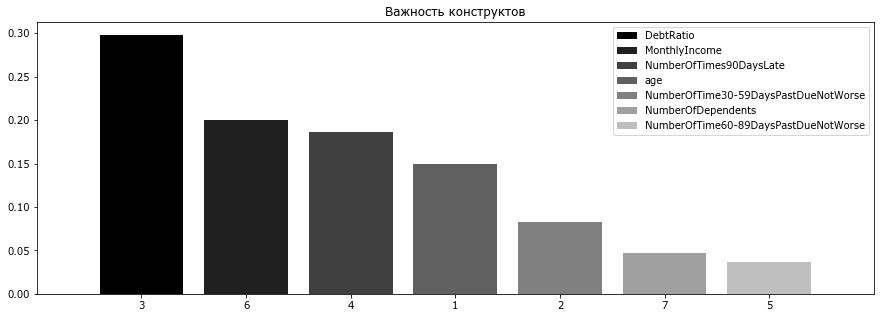

In [43]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import seaborn as sns
# russian headres
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)
import pandas as pd
import numpy as np
from sklearn.ensemble.forest import RandomForestRegressor

features = {"f1":u"age",
"f2":u"NumberOfTime30-59DaysPastDueNotWorse",
"f3":u"DebtRatio",
"f4":u"NumberOfTimes90DaysLate",
"f5":u"NumberOfTime60-89DaysPastDueNotWorse",
"f6":u"MonthlyIncome",
"f7":u"NumberOfDependents"}

forest = RandomForestRegressor(
    n_estimators=1000, 
    max_features=7,
    random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 7
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            features["f"+str(feature_indices[f])], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Важность конструктов")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) 
                  for i in feature_indices]);


In [44]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами 
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                            random_state=42, oob_score=True, 
                            class_weight='balanced')

## Будем искать лучшие параметры среди следующего набора
parameters = {'max_features': [1, 2, 4], 
              'min_samples_leaf': [3, 5, 7, 9], 
              'max_depth': [5,10,15]}

## Делаем опять же стрэтифайд k-fold валидацию. Инициализация которой должна у вас продолжать храниться в skf
from sklearn.metrics import roc_auc_score, make_scorer

scorer = make_scorer(roc_auc_score)

gcv = GridSearchCV(
    rf, 
    parameters, 
    n_jobs=-1, 
    cv=skf, 
    verbose=1, 
    scoring=scorer)

gcv.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  5.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=True, random_state=42,
            verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=1)

In [45]:
gcv.score(X, y)

0.7771860206873381

Populating the interactive namespace from numpy and matplotlib
Feature ranking:
1. DebtRatio 0.297996 
2. MonthlyIncome 0.200164 
3. NumberOfTimes90DaysLate 0.185692 
4. age 0.149302 
5. NumberOfTime30-59DaysPastDueNotWorse 0.083185 
6. NumberOfDependents 0.047421 
7. NumberOfTime60-89DaysPastDueNotWorse 0.036242 


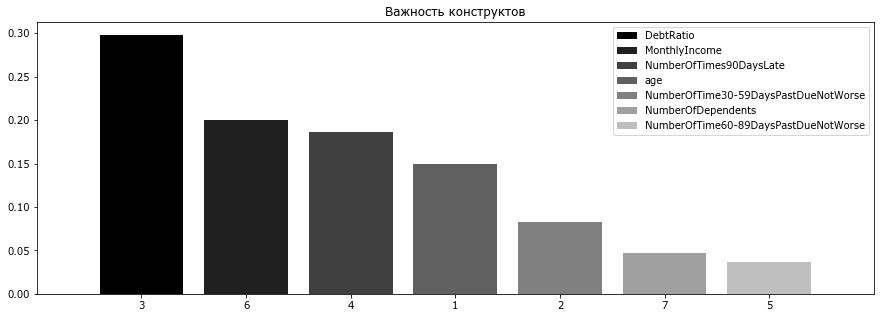

In [49]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import seaborn as sns
# russian headres
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)
import pandas as pd
import numpy as np
from sklearn.ensemble.forest import RandomForestRegressor

features = {"f1":u"age",
"f2":u"NumberOfTime30-59DaysPastDueNotWorse",
"f3":u"DebtRatio",
"f4":u"NumberOfTimes90DaysLate",
"f5":u"NumberOfTime60-89DaysPastDueNotWorse",
"f6":u"MonthlyIncome",
"f7":u"NumberOfDependents"}

forest = RandomForestRegressor(
    n_estimators=1000, 
    max_features=7,
    random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 7
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            features["f"+str(feature_indices[f])], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Важность конструктов")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) 
                  for i in feature_indices]);

In [50]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100]}

In [61]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
%matplotlib inline

np.random.seed(42)
X, y = make_circles(n_samples=500, factor=0.1, noise=0.35, random_state=42)
X_train_circles, X_test_circles, y_train_circles, y_test_circles = train_test_split(X, y, test_size=0.2)

lr = LogisticRegression(random_state=5, class_weight= 'balanced')
rs = RandomizedSearchCV(lr, parameters, cv=skf)

b_dtree = BaggingClassifier(rs,n_estimators=100, random_state=42, max_samples=20)
b_dtree.fit(X_train_circles, y_train_circles)

"""
x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = b_dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.title("Бэггинг(grid search cv)")
plt.show()
"""

ValueError: Invalid parameter max_samples for estimator LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2',
          random_state=1952926171, solver='warn', tol=0.0001, verbose=0,
          warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.